In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import pearsonr
from datetime import datetime
from datetime import timedelta
from haversine import haversine
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from math import sqrt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import lightgbm as lgbm
import numpy as np
import seaborn

/home/sandeepkumta_vishnu/dsf/dsf2/env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sandeepkumta_vishnu/dsf/dsf2/env/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Reading input data into pandas dataframe
train_df = pd.read_csv('../input/train.csv', nrows=10000000)
train_df['pickup_datetime'] = train_df['pickup_datetime'].str.slice(0, 19)
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M:%S')

In [3]:
# Data Cleaning

print('Total null values:', train_df.isnull().sum())
train_df.dropna(inplace=True)

# Drop null and invalid values
train_df.drop(train_df[(train_df.fare_amount <= 0.0) | (train_df.fare_amount > 500.0)].index, inplace=True)
train_df.drop(train_df[train_df.passenger_count < 0].index, inplace=True)
train_df.drop(train_df[train_df.passenger_count > 6].index, inplace=True)
train_df.drop(train_df[train_df.pickup_latitude > 90].index, inplace=True)
train_df.drop(train_df[train_df.pickup_latitude < -90].index, inplace=True)
train_df.drop(train_df[train_df.pickup_longitude > 180].index, inplace=True)
train_df.drop(train_df[train_df.pickup_longitude < -180].index, inplace=True)
train_df.drop(train_df[train_df.dropoff_latitude > 90].index, inplace=True)
train_df.drop(train_df[train_df.dropoff_latitude < -90].index, inplace=True)
train_df.drop(train_df[train_df.dropoff_longitude > 180].index, inplace=True)
train_df.drop(train_df[train_df.dropoff_longitude < -180].index, inplace=True)
print('Dropping Invalid Values: Done')
print('Current Shape:', train_df.shape)

# Drop values outside of NYC range from https://www.mapdevelopers.com/geocode_bounding_box.php
nyc_limits = { 'nyc_latitude_min' : 40.477399, 'nyc_latitude_max' : 40.917577, 'nyc_longitude_min':  -74.259090, 'nyc_longitude_max':-73.700272}
train_df.drop(index=train_df[(train_df.pickup_latitude < nyc_limits['nyc_latitude_min'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.pickup_latitude > nyc_limits['nyc_latitude_max'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.dropoff_latitude < nyc_limits['nyc_latitude_min'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.dropoff_latitude > nyc_limits['nyc_latitude_max'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.pickup_longitude < nyc_limits['nyc_longitude_min'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.pickup_longitude > nyc_limits['nyc_longitude_max'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.dropoff_longitude < nyc_limits['nyc_longitude_min'])].index, inplace=True)
train_df.drop(index=train_df[(train_df.dropoff_longitude > nyc_limits['nyc_longitude_max'])].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)
print('Dropping Values outside NYC: Done')
print('Current Shape:', train_df.shape)
print('Cleaning Done:')

Total null values: key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64
Dropping Invalid Values: Done
Current Shape: (9998745, 8)
Dropping Values outside NYC: Done
Current Shape: (9775622, 8)
Cleaning Done:


In [4]:
def get_time_of_the_day_bin(time_in_utc):
    time_of_the_day_bin = time_in_utc.hour // 4
    return time_of_the_day_bin

In [5]:
train_df['time_of_the_day_bin'] = train_df.apply(lambda each: get_time_of_the_day_bin(each['pickup_datetime']),axis=1)

In [6]:
train_df['year']=train_df['pickup_datetime'].dt.year
train_df['month']=train_df['pickup_datetime'].dt.month
train_df['weekdayname']=train_df['pickup_datetime'].dt.weekday_name
train_df['weekday']=train_df['pickup_datetime'].dt.weekday
train_df['hour']=train_df['pickup_datetime'].dt.hour

In [7]:
def euclidean_distance(x1,y1,x2,y2):
    p1 = (x1,y1)
    p2 = (x2,y2)
    return distance.euclidean(p1,p2)

In [8]:
train_df['euclid_distance'] = train_df.apply(lambda each: euclidean_distance(each.pickup_latitude, each.pickup_longitude,each.dropoff_latitude, each.dropoff_longitude), axis=1)

In [9]:
def geo_distance(x1,y1,x2,y2):
    return haversine((x1, y1), (x2, y2))

In [10]:
train_df['geo_distance'] = train_df.apply(lambda each: geo_distance(each.pickup_latitude, each.pickup_longitude,each.dropoff_latitude, each.dropoff_longitude), axis=1) 

In [11]:
correlation1, _ = pearsonr(train_df['fare_amount'], train_df['euclid_distance'])
correlation2, _ = pearsonr(train_df['hour'], train_df['geo_distance'])
correlation3, _ = pearsonr(train_df['hour'], train_df['fare_amount'])
print('Correlation between fare amount and euclidean distance: ', correlation1)
print('Correlation between time of the day and distance travelled: ', correlation2)
print('Correlation between time of the day and fare amount : ',correlation3)

Correlation between fare amount and euclidean distance:  0.8745327868586416
Correlation between time of the day and distance travelled:  -0.02905541749157523
Correlation between time of the day and fare amount :  -0.01723233250913113


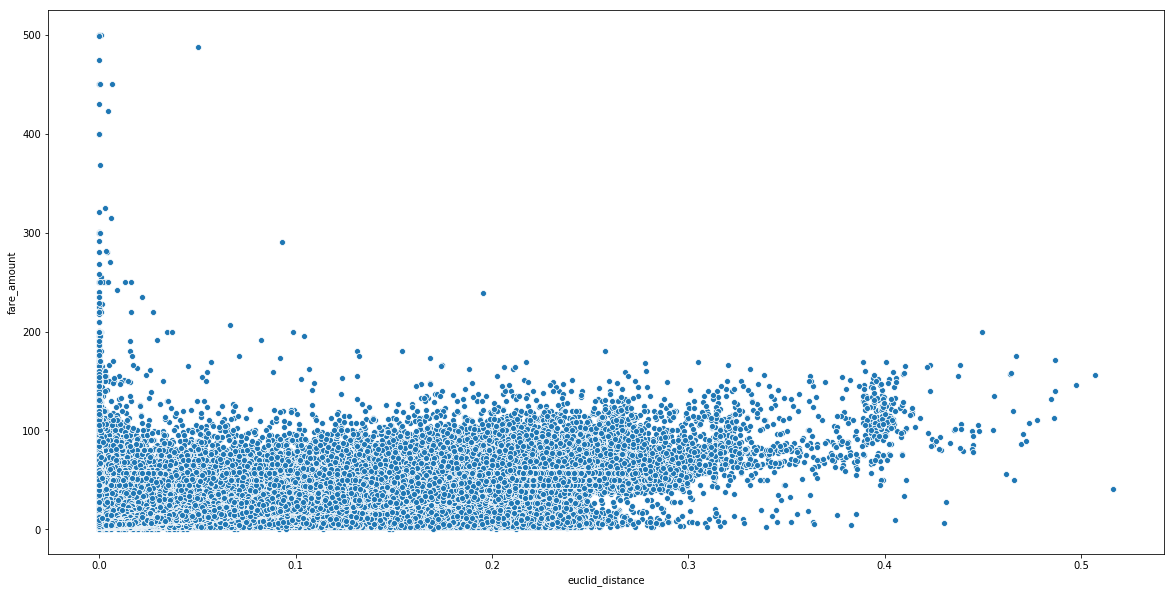

In [12]:
plt.figure(figsize=(20,10))
scatter_plot =seaborn.scatterplot(x="euclid_distance", y="fare_amount", data=train_df)
plt.savefig('./images/euclideanvsfareamount.png')

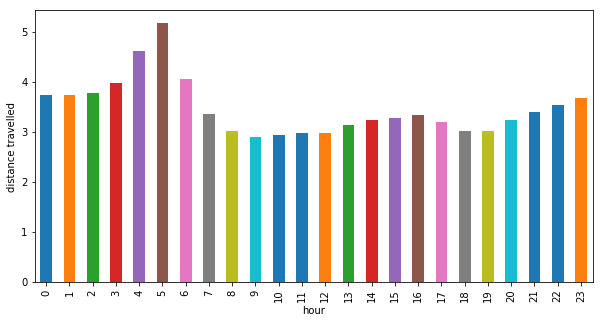

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(10,5))
plt.xlabel("time of the day")
plt.ylabel("distance travelled")
train_df.groupby('hour')['geo_distance'].mean().plot(kind='bar')
plt.show()
plt.savefig('./images/hourvsgeodistance.png')

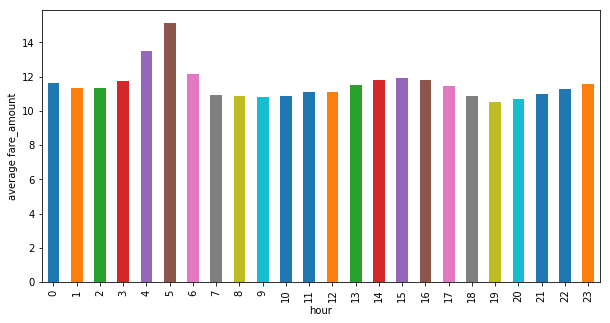

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(10,5))
plt.xlabel("time of the day")
plt.ylabel("average fare_amount")
train_df.groupby('hour')['fare_amount'].mean().plot(kind='bar')
plt.show()
plt.savefig('./images/hourvsfareamount.png')

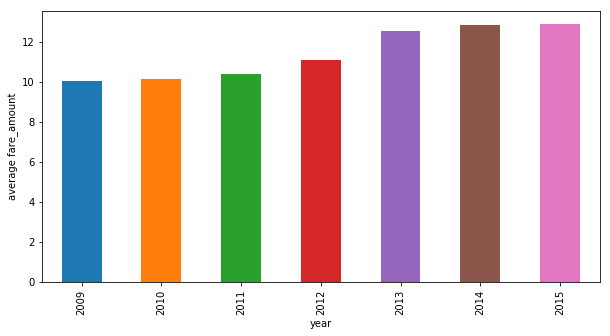

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(10,5))
plt.xlabel("year")
plt.ylabel("average fare_amount")
train_df.groupby('year')['fare_amount'].mean().plot(kind='bar')
plt.show()
plt.savefig('./images/yearvsfareamount.png')

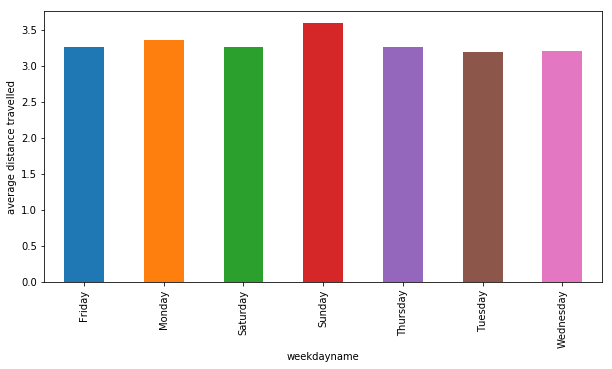

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(figsize=(10,5))
plt.xlabel("weekday")
plt.ylabel("average distance travelled")
train_df.groupby('weekdayname')['geo_distance'].mean().plot(kind='bar')
plt.show()
plt.savefig('./images/weekdaynamevsgeodistance.png')

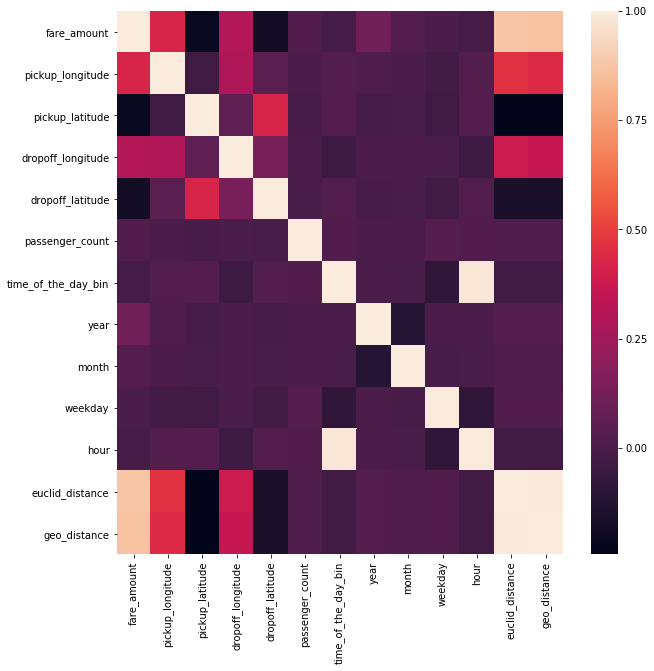

In [17]:
plt.figure(figsize=(10,10))
seaborn.heatmap(train_df.corr())
plt.savefig('./images/heatmapsimple.png')

In [18]:
test_df = pd.read_csv('../input/test.csv')
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 19)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M:%S')

# Euclidean Distance feature
test_df['euclid_distance'] = test_df.apply(lambda each: euclidean_distance(each.pickup_latitude, each.pickup_longitude,each.dropoff_latitude, each.dropoff_longitude), axis=1)
print('euclid_distance : Done')

# Geo Distance feature
test_df['geo_distance'] = test_df.apply(lambda each: geo_distance(each.pickup_latitude, each.pickup_longitude,each.dropoff_latitude, each.dropoff_longitude), axis=1)
print('geo_distance : Done')

# Time of the Day feature
test_df['time_of_the_day_bin'] = test_df.apply(lambda each: get_time_of_the_day_bin(each['pickup_datetime']),axis=1)
print('time_of_the_day_bin : Done')

# Add various time features
test_df['year']=test_df['pickup_datetime'].dt.year
test_df['month']=test_df['pickup_datetime'].dt.month
test_df['weekdayname']=test_df['pickup_datetime'].dt.weekday_name
test_df['weekday']=test_df['pickup_datetime'].dt.weekday
test_df['hour']=test_df['pickup_datetime'].dt.hour
print('various time features : Done')

euclid_distance : Done
geo_distance : Done
time_of_the_day_bin : Done
various time features : Done


In [19]:
columns_to_use=['euclid_distance', 'year', 'weekday', 'hour', 'month', 'geo_distance', 'time_of_the_day_bin']
X = train_df[columns_to_use]
y = train_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [20]:
linear_model=LinearRegression()
linear_model.fit(X_train,y_train)
y_predicted = linear_model.predict(X_test)
print('Simple Linear Model Score: ',linear_model.score(X_test, y_test))
print('Simple Linear Model Root Mean Square Error', sqrt(mean_squared_error(y_test, y_predicted)))

Simple Linear Model Score:  0.7758199270469899
Simple Linear Model Root Mean Square Error 4.476185560590762


In [21]:
print('Linear Regression Coefficients: \n', linear_model.coef_)

Linear Regression Coefficients: 
 [ 2.53196944e+02  5.01030549e-01 -3.68318224e-02 -1.71906945e-02
  6.91286051e-02 -3.97412171e-01  1.19644409e-01]


In [22]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train,y_train)
y_predicted = ridge_model.predict(X_test)
print('Linear Model with Ridge regularization Score: ',linear_model.score(X_test, y_test))
print('Linear Model with Ridge regularization Root Mean Square Error', sqrt(mean_squared_error(y_test, y_predicted)))

Linear Model with Ridge regularization Score:  0.7758199270469899
Linear Model with Ridge regularization Root Mean Square Error 4.4761846321014005


In [23]:
# K-Fold Cross Validation
k_fold = cross_validation.KFold(len(X), 10)
k = 1
for (train, test) in k_fold:
    train_start_index = train[0]
    train_end_index = train[-1]
    linear_model.fit(X[train_start_index:train_end_index], y[train_start_index:train_end_index])
    test_start_index = test[0]
    test_end_index = test[-1]    
    print('Score in Fold ',k,': ', linear_model.score(X[test_start_index:test_end_index], y[test_start_index:test_end_index]))
    k = k+1

Score in Fold  1 :  0.7683709151886802
Score in Fold  2 :  0.7749025676718191
Score in Fold  3 :  0.7755576338203055
Score in Fold  4 :  0.7765298220338211
Score in Fold  5 :  0.7792054812098081
Score in Fold  6 :  0.7757281346461625
Score in Fold  7 :  0.7763039897546378
Score in Fold  8 :  0.7656640150389048
Score in Fold  9 :  0.7779150991678034
Score in Fold  10 :  0.7805759773030445


In [24]:
# US Federal Holidays External Dataset

holidays = USFederalHolidayCalendar().holidays(start='2009-01-01', end='2016-12-31')
train_df['is_holiday'] = train_df.pickup_datetime.apply(lambda each: 0 if each not in holidays else 1)
test_df['is_holiday'] = test_df.pickup_datetime.apply(lambda each: 0 if each not in holidays else 1)

In [25]:
correlation4, _ = pearsonr(train_df['is_holiday'], train_df['fare_amount'])
print('Correlation between is_holiday and fareamount', correlation4)

Correlation between is_holiday and fareamount 7.030613107563704e-05


In [26]:
def get_prvious_mondays_price(date_in_timestamp):
    date_object = date_in_timestamp.to_pydatetime()
    previous_monday = date_object - timedelta(days=date_object.weekday())
    return fuel_price_dictionary[previous_monday.strftime('%m/%d/%Y')]

# External Dataset of fuel price  
fuel_price_df = pd.read_csv('../input/gasoline_price_weekly_average_by_region.csv')[['Date','New York City Average ($/gal)']]
fuel_price_dictionary = dict([(row['Date'], row['New York City Average ($/gal)']) for index, row in fuel_price_df.iterrows()])

In [27]:
train_df['fuel_price_per_gallon'] = train_df.apply(lambda each: get_prvious_mondays_price(each['pickup_datetime']),axis=1)
test_df['fuel_price_per_gallon'] = test_df.apply(lambda each: get_prvious_mondays_price(each['pickup_datetime']),axis=1)

In [28]:
correlation5, _ = pearsonr(train_df['fuel_price_per_gallon'], train_df['fare_amount'])
print('Correlation between fuel price per gallon and fareamount', correlation4)

Correlation between fuel price per gallon and fareamount 7.030613107563704e-05


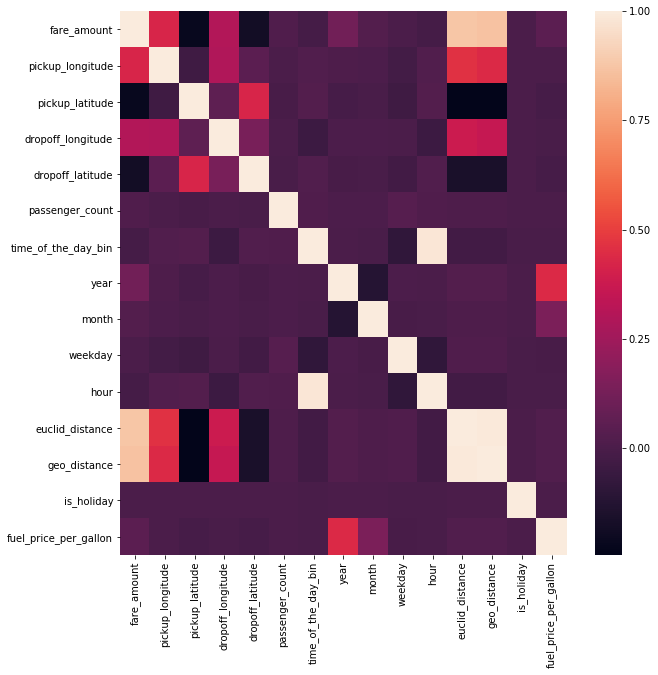

In [29]:
plt.figure(figsize=(10,10))
seaborn.heatmap(train_df.corr())
plt.savefig('./images/heatmapmorefeatures.png')

In [30]:
# Save cleaned and added features dataframe as a file for faster modelling later
train_df.to_csv('../input/ten_million_cleaned_dataset_final.csv', index=False)

In [31]:
columns_to_use=['euclid_distance', 'year', 'weekday', 'hour', 'month', 'geo_distance', 'time_of_the_day_bin', 'fuel_price_per_gallon', 'is_holiday']
X = train_df[columns_to_use]
y = train_df['fare_amount']

In [32]:
# Support Vector Regressor
support_vector_regressor = SVR(kernel='rbf', C=1e3, gamma=0.1)
support_vector_regressor.fit(X, y)
y_predicted = support_vector_regressor.predict(test_df[columns_to_use])

In [33]:
# Neural Network
neural_network = MLPRegressor(hidden_layer_sizes=(30,30,30))
neural_network.fit(X,y)
y_predicted = neural_network.predict(test_df[columns_to_use])

In [34]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=5, max_features=None, max_depth=10, min_samples_split=4, min_samples_leaf=3, random_state=0)
rf_model.fit(X, y)
y_predicted = rf_model.predict(test_df[columns_to_use])

In [35]:
# Submission for Random Forest Regressor
submission = pd.read_csv('../input/sample_submission.csv')
submission['fare_amount'] = y_predicted
submission.to_csv('submission_rf.csv',index=False)